# Filtr Kalmana

Na podstawie <https://www.kalmanfilter.net/>

## Wprowadzenie i podstawowe pojęcia

**Średnia** (*mean*) - średnia wartość obliczona na podstawie znanego stanu **całej** populacji

$$ V_{mean} = \frac{1}{N}\sum^{N}_{n=1}V_n $$

In [1]:
import numpy as np

coin_values = np.array([5, 5, 10, 10, 10])
mean = np.mean(coin_values)

print(f"Wartości: {coin_values}")
print(f"Średnia: {mean}")

Wartości: [ 5  5 10 10 10]
Średnia: 8.0


**Wartość oczekiwana** (*expected value*) - wartość określająca spodziewany wynik ukrytej zmiennej

$$ W = \frac{1}{N}\sum^{N}_{n=1}W_n $$

In [2]:
import numpy as np

generator = np.random.default_rng()

random_values = np.array(generator.normal(loc=80.0, scale=0.5, size=5))
expected_value = np.mean(random_values)

print(f"Losowe wartości: {random_values}")
print(f"Wartość oczekiwana: {expected_value}")

Losowe wartości: [80.74324402 79.49596333 79.65104813 80.13567995 80.48591002]
Wartość oczekiwana: 80.10236909002734


**Wariancja** (*variance*) - miara rozrzutu wartości zbioru od jego średniej

$$ \sigma^2 = \frac{1}{N} \sum^{N}_{n=1}(x_n - \mu)^2 $$

In [3]:
import numpy as np

# zakładamy że jest to cała populacja
values = np.array(generator.normal(loc=1.9, scale=0.2, size=5))
mean = np.mean(values)
variance = np.var(values)

print(f"Wartości: {values}")
print(f"Średnia: {mean}")
print(f"Wariancja: {variance}")

Wartości: [1.49711146 1.82752921 1.74297903 1.91240238 1.87402993]
Średnia: 1.7708104014037158
Wariancja: 0.021921055608936642


**Odchylenie standardowe** (*standard deviation*) - pierwiastek kwadratowy wariancji 

$$ \sigma = \sqrt{\sigma^2} = \sqrt{\frac{1}{N} \sum^{N}_{n=1}(x_n - \mu)^2} $$

In [4]:
import numpy as np

std_deviation = np.std(values)
print(f"Odchylenie standardowe: {std_deviation}")

Odchylenie standardowe: 0.14805760908827564


Podczas **estymacji** wariancji i odchylenia standardowego z **części populacji** należy zastosować dzielnik $\frac{1}{N-1}$ zamiast $\frac{1}{N}$ (Poprawka Bessela)

$$ \sigma = \sqrt{\sigma^2} = \sqrt{\frac{1}{N - 1} \sum^{N}_{n=1}(x_n - \mu)^2} $$

### Rozkład normalny (*normal distribution*)

Rozkład normalny (rozkład Gaussa) to krzywa dzwonowa opisana następującym wzorem:

$$ f(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}}e^{\frac{-(x-\mu)^2}{2\sigma^2}} $$


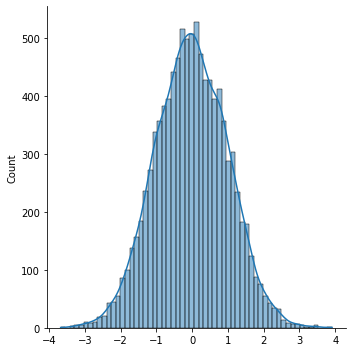

In [5]:
import seaborn as sns

values = generator.normal(loc=0.0, scale=1.0, size=10000)
sns.displot(values, kde=True)

### Estymacja, dokładność i precyzja

**Estymacja** (oszacowanie) polega na ocenie ukrytego stanu danego systemu. Przykładem może być pozycja samolotu - nie znamy dokładnej pozycji, ale możemy ją estymować za pomocą odpowiednich czujników, takich jak radar. W przypadku pojazdów naziemnych, możemy estymować pozycję na podstawie odometrów (na przykład enkoderów) lub czujników inercyjnych.

Estymacja może być znacznie poprawiona poprzez użycie różnych źródeł danych i aplikację filtrów oraz algorytmów pomagających w śledzeniu (takich jak filtr Kalmana). Każda wartość którą obliczymy na podstawie takich obserwacji jest estymatą.

**Dokładność** (*accuracy*) określa jak blisko prawdziwej wartości jest wartość zmierzona.
**Precyzja** (*precision*) określa jak bardzo różnią się od siebie wartości zmierzone dla tej samej wartości parametru (jak szeroko są rozsiane, jak duże jest ich odchylenie standardowe).

Systemy o wysokiej precyzji mają niską wariancję pomiarów, a systemy o niskiej precyzji - wysoką. Wariancja jest efektem losowego błędu pomiarowego.

Systemy o niskiej dokładności wprowadzają systematyczne przekłamanie (*bias*), które można stosunkowo łatwo wyeliminować poprzez odjęcie go od pomiarów, jeśli wiemy ile wynosi. Jeśli nie wiemy, lub nie możemy tego sprawdzić, nie ma innej możliwości na skompensowanie tego błędu.

Niską precyzję można skompensować poprzez uśrednianie zmierzonych wartości.

## Filtr alfa-beta-gamma

### Przykład 1 - pomiar wagi sztabek złota

Sztabka złota to system statyczny - nie zmienia swojego stanu w czasie w którym go rozpatrujemy.
Do pomiaru wagi użyjemy wagi z zerowym przekłamaniem (*biasem*), ale każdy pomiar będzie obarczony pewnym błędem.

Żeby estymować stan systemu (wagę sztabki), możemy wykonać kilka pomiarów i je uśrednić

W momencie $n$, estymata $\hat{x}_{n,n}$ będzie średnią wszystkich poprzednich pomiarów:

$$ \hat{x}_{n,n} = \frac{1}{n}(z_1 + z_2 + ... + z_{n-1} + z_n) = \frac{1}{n}\sum^{n}_{i=1}(z_i) $$

gdzie:

* $x$ to prawdziwa wartość wagi (której nie znamy, a którą estymujemy)
* $z_n$ to pomiar wartości w momencie $n$
* $\hat{x}_{n,n}$ to estymata $x$ w momencie $n$ (po wykonaniu pomiaru $z_n$)
* $\hat{x}_{n,n-1}$ to poprzednia estymata $x$ w momencie $n-1$ (po wykonaniu pomiaru $z_{n-1}$)
* $\hat{x}_{n+1,n}$ to estymata **przyszłego** stanu $(n+1)$ zmiennej $x$. Estymata ta jest obliczona w momencie $n$ (po wykonaniu pomiaru $z_n$). Innymi słowy, jest to przewidywany stan systemu.

W tym przypadku, dynamiczny model systemu jest stały, więc $\hat{x}_{n+1,n} = \hat{x}_{n,n}$

Powyższy wzór nie jest optymalny dla naszych zastosowań, ponieważ wymaga on trzymania wszystkich zmierzonych wartości w pamięci i obliczania wszystkich poprzednich stanów w celu estymacji kolejnego. Możemy nieco zmodyfikować ten wzór do poniższej postaci (pełny dowód przedstawiony jest tutaj: <https://www.kalmanfilter.net/alphabeta.html>)

$$ \hat{x}_{n,n} = \frac{1}{n}\sum^{n}_{i=1}(z_i) = \hat{x}_{n-1,n-1} + \frac{1}{n}(z_n - \hat{x}_{n-1,n-1}) $$

gdzie $\hat{x}_{n-1,n-1}$ jest estymowanym stanem zmiennej $x$ w momencie $n-1$, obliczonym na podstawie pomiaru wykonanego w momencie $n-1$.

Jak wyżej wspomniałem, analizowany przez nas system jest statyczny, co oznacza że przewidywany stan systemu powinien być równy estymowanemu stanowi, co można zapisać w następujący sposób: $\hat{x}_{n,n-1} = \hat{x}_{n-1,n-1}$

Na tej podstawie, można zapisać wzór na estymację aktualnego stanu na podstawie stanów poprzednich:

$$ \hat{x}_{n,n} = \hat{x}_{n,n-1} + \frac{1}{n}(z_n - \hat{x}_{n,n-1}) $$

Równanie to jest jednym z pięciu równań filtra Kalmana - równanie aktualizacji stanu (*State Update Equation*).

Tłumacząc je na język naturalny, oznacza ono że **estymata aktualnego stanu** jest równa **przewidywanej wartości stanu** plus **mnożnik** razy (**wartość pomiaru** minus **przewidywana wartość stanu**).
Mnożnik $\frac{1}{n}$ jest specyficzny dla naszego przypadku - w filtrze Kalmana nazwany jest **wzmocnieniem kalmana** (*Kalman Gain*) i zmienia się z kolejnymi iteracjami filtru.

Podstawiając $\alpha_n$ za nasz mnożnik, otrzymujemy następujące równanie aktualizacji stanu:

$$ \hat{x}_{n,n} = \hat{x}_{n,n-1} + \alpha_n (z_n - \hat{x}_{n,n-1}) $$

$ (z_n - \hat{x}_{n,n-1}) $ to fragment z pomiarem, nazywany również **innowacją**, ponieważ dostarcza nowe informacje.

W naszym przypadku, mnożnik $\frac{1}{n}$ zmniejsza się wraz z ilością pomiarów. Oznacza to że na początku nie mamy wystarczająco dużo informacji o aktualnym stanie, więc nowe wartości dostarczane do naszego estymatora będą miały większą wagę. Wraz z pojawianiem się kolejnych danych, będą one mieć coraz mniejszy wpływ na końcowy wynik.

Zanim wykonamy pierwszy pomiar, potrzebujemy jakiejś wartości systemu za pomocą której zainicjalizujemy nasz filtr - im bliższa jest ona prawdziwemu stanowi, tym lepiej. Wartość ta nazywana jest **wstępną wartością** (*initial guess*).

#### Algorytm estymacji

Poniższy flowchart przedstawia algorytm estymacji wykorzystany w tym przykładzie:

![est_1](./img//ex1_estimationAlgorithm.png)

#### Przykład numeryczny

##### Iteracja 0

**Inicjalizacja**

Załóżmy że sztabka waży 1000 gram. Ta wartość będzie wykorzystana jako wstępna wartość dla algorytmu.

$$ \hat{x}_{0,0} = 1000g $$

**Predykcja**

Waga sztabki nie powinna się zmienić (system jest statyczny), więc nasza estymata wynosi tyle samo co aktualny stan systemu

$$ \hat{x}_{1,0} = \hat{x}_{0,0} = 1000g $$

##### Iteracja 1

**Krok 1**

Wykonujemy pomiar

$$ z_1 = 1030g $$

**Krok 2**

Obliczamy mnożnik. W naszym przykładzie, $\alpha_n = \frac{1}{n}$, więc

$$ \alpha_1 = \frac{1}{1} = 1 $$

Następnie obliczamy aktualną estymację stanu systemu za pomocą równania aktualizacji stanu

$$ \hat{x}_{1,1} = \hat{x}_{1,0} + \alpha_1 (z_1 - \hat{x}_{1,0}) = 1000 + 1(1030 - 1000) = 1030g $$

W tym konkretnym przypadku pierwsza zmierzona wartość zastąpiła wstępną wartość, ponieważ $\alpha_1 = 1$,

**Krok 3**

Dynamiczny model systemu jest statyczny - nie przewidujemy że waga sztabki się zmieni - więc przewidywany stan systemu jest równy aktualnemu, estymowanemu stanowi

$$ \hat{x}_{2,1} = \hat{x}_{1,1} = 1030g $$

##### Iteracja 2

Po odstępie czasowym, przewidywany stan systemu z poprzedniej iteracji staje się poprzednią estymatą

$$ \hat{x}_{2,1} = 1030g $$

**Krok 1**

Wykonujemy kolejny pomiar

$$ z_2 = 989g $$

**Krok 2**

Obliczamy mnożnik

$$ \alpha_2 = \frac{1}{2} $$

oraz aktualną estymację

$$ \hat{x}_{2,2} = \hat{x}_{2,1} + \alpha_2 (z_2 - \hat{x}_{2,1}) = 1030 + \frac{1}{2}(989 - 1030) = 1009.5g $$

**Krok 3**

$$ \hat{x}_{3,2} = \hat{x}_{2,2} = 1009.5g $$

etc, etc.

Poniżej algorytm w postaci kodu, oraz wynik jego działania

   n  Measurements    Estimates  True value
0  0          1030  1030.000000        1010
1  1           989  1009.500000        1010
2  2          1017  1012.000000        1010
3  3          1009  1011.250000        1010
4  4          1013  1011.600000        1010
5  5           979  1006.166667        1010
6  6          1008  1006.428571        1010
7  7          1042  1010.875000        1010
8  8          1012  1011.000000        1010
9  9          1011  1011.000000        1010


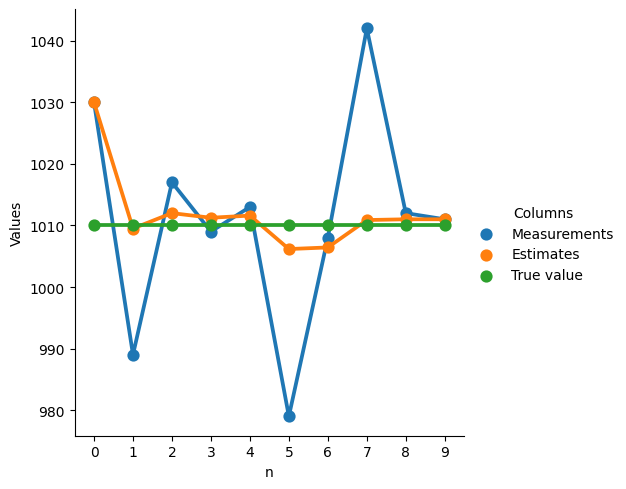

In [6]:
import pandas as pd
import seaborn as sns


def factor(value_index: int) -> float:
    return 1.0 / float(value_index)


def current_estimate(
    predicted_value: float, value_index: int, measurement: float
) -> float:
    return predicted_value + (factor(value_index) * (measurement - predicted_value))


initial_guess = 1000
true_value = 1010
measurements = [1030, 989, 1017, 1009, 1013, 979, 1008, 1042, 1012, 1011]
# oblicz pierwszą estymatę
estimates = [current_estimate(initial_guess, 1, measurements[0])]
# oblicz resztę
for n in range(1, len(measurements)):
    estimates.append(current_estimate(estimates[n - 1], n + 1, measurements[n]))

# stwórz ramkę danych do wizualizacji

df = pd.DataFrame(
    {
        "n": list(range(len(measurements))),
        "Measurements": measurements,
        "Estimates": estimates,
        "True value": [true_value] * len(measurements),
    }
)

sns_df = df.melt("n", var_name="Columns", value_name="Values")

print(df)

sns.catplot(data=sns_df, x="n", y="Values", hue="Columns", kind="point")


Możemy zauważyć że nasz algorytm dość precyzyjnie estymował prawdziwą wartość wagi sztabki złota, która wynosi 1010g. Widzimy również że im więcej pomiarów zostało wykonanych, tym mniejszy wpływ mają na estymowaną wartość.

### Przykład 2 - śledzenie trasy samolotu lecącego ze stałą prędkością (filtr alfa-beta)

Ten przykład skupi się na dynamicznym systemie, który zmienia swój stan w czasie. Konkretnie, będziemy śledzić samolot lecący ze stałą prędkością za pomocą filtra $\alpha$-$\beta$

Przyjmijmy że opisywany samolot porusza się w jednowymiarowej przestrzeni i oddala się od radaru za pomocą którego będziemy mierzyli jego odległość w czasie. W jednowymiarowym świecie, kąt radaru w stosunku do samolotu jest stały, jak również i wysokość na której porusza się samolot.

$x_n$ będzie odległością między radarem a samolotem w momencie $n$. Prędkość samolotu jest zdefiniowana jako zmiana odległości w czasie - innymi słowy, jest to pochodna odległości.

$$ \dot{x} = v = \frac{dx}{dt} $$

Zakładając że prędkość jest stała, dynamiczny model systemu może być opisany dwoma równaniami ruchu:

$$ x_{n+1} = x_n + \Delta t \dot{x}_n $$
$$ \dot{x}_{n+1} = \dot{x}_n $$

Równania te mówią, że odległość samolotu w momencie $(n+1)$-tego pomiaru jest równa odległości w momencie $n$-tego pomiaru, plus szybkości samolotu pomnożonej przez czas między pomiarami. Zakładamy również że prędkość jest stała, więc prędkość w $(n+1)$-tym momencie będzie taka sama jak w $n$-tym momencie.

Powyższe równania nazywane są równaniami ekstrapolacji stanu (*State Extrapolation Equation*), lub równaniami przejścia/predykcji (*Transition*/*Prediction Equation*) i są jednymi z równań występujących w filtrze Kalmana. Pozwalają one na ekstrapolację aktualnego stanu systemu na przyszły stan - czyli predykcję stanu.

W poprzednim przykładzie również zastosowane było równanie ekstrapolacji stanu, lecz ze względu na statyczność systemu było ono równe poprzedniemu stanowi. Przedstawione wyżej równania ekstrapolacji stanu są specyficzne dla naszego przypadku, musimy jeszcze zmodyfikować równania aktualizacji stanu.

#### Filtr alfa-beta

Załóżmy że czas między pomiarami radaru $\Delta t$ wynosi 5 sekund. Załóżmy również ze w momencie $(n-1)$ odległość samolotu od radaru wynosi 30000m, a szybkość 40m/s.
Za pomocą równań ekstrapolacji stanu możemy przewidzieć pozycję samolotu w momencie $n$:

$$ \hat{x}_{n,n-1} = \hat{x}_{n-1,n-1} + \Delta t \hat{\dot{x}}_{n-1,n-1} = 30000m + 5s \cdot 40m/s = 30200m $$

Szybkość samolotu w momencie $n$ wynosi

$$ \hat{\dot{x}}_{n,n-1} = \hat{\dot{x}}_{n-1,n-1} = 40m/s $$

Radar w momencie $n$ zmierzył odległość $z_n$ równą 30110m, a nie 30200m - którą obliczyliśmy. Różnica wynosi 90m i istnieją dwa potencjalne powody przez które się pojawiła:
* Pomiar wykonywany przez radar nie jest dokładny
* Szybkość samolotu się zmieniła. Nowa szybkość samolotu, obliczona na podstawie pomiaru, wynosi $\frac{30110m - 30000m}{5s} = 22m/s$

Nie wiemy jednak który z tych powodów jest prawdziwy.

Rozpiszmy równania aktualizacji stanu dla szybkości:

$$ \hat{\dot{x}}_{n,n} = \hat{\dot{x}}_{n,n-1} + \beta \left( \frac{z_n - \hat{x}_{n,n-1}}{\Delta t} \right) $$

Wartość współczynnika $\beta$ zależy od dokładności radaru. Możemy więc nią manipulować. Załóżmy że $\sigma$ (odchylenie standardowe) błędu pomiarowego radaru wynosi 20m. W takim przypadku, różnica rzędu 90m najprawdopodobniej wynika ze zmiany szybkości samolotu, ponieważ jest to znacznie większa wartość niż $\sigma$. Powinniśmy więc w takim przypadku ufać odczytowi z radaru bardziej niż naszej predykcji, więc współczynnik $\beta$ powinien być większy. Przy założeniu że $\beta$ wynosi 0.9, obliczamy następującą szybkość:

$$ \hat{\dot{x}}_{n,n} = \hat{\dot{x}}_{n,n-1} + \beta \left( \frac{z_n - \hat{x}_{n,n-1}}{\Delta t} \right) = 40m/s + 0.9 \left( \frac{30110m - 30200m}{5s} \right) = 23.8m/s $$

Z kolei jeśli $\sigma$ miałaby wartość 150m, to jest ona większa od różnicy 90m którą otrzymaliśmy, więc można założyć że wzięła się ona ze względu na błąd pomiarowy. W takim przypadku $\beta$ powinna być mała, na przykład 0.1, co dałoby nam szybkość

$$ \hat{\dot{x}}_{n,n} = \hat{\dot{x}}_{n,n-1} + \beta \left( \frac{z_n - \hat{x}_{n,n-1}}{\Delta t} \right) = 40m/s + 0.1 \left( \frac{30110m - 30200m}{5s} \right) = 38.2m/s $$

Współczynnik $\beta$, w przeciwieństwie do współczynnika $\alpha$ z poprzedniego przykładu, nie zmienia się co iterację - jest on stały w naszym przypadku, oraz ściśle zależny od dokładności narzędzia pomiarowego.

Równania aktualizacji stanu dla szybkości i pozycji są nazywane równaniami aktualizacji $\alpha$-$\beta$.

Dla pozycji:

$$ \hat{x}_{n,n} = \hat{x}_{n,n-1} + \alpha (z_n - \hat{x}_{n,n-1}) $$

Dla szybkości:

$$ \hat{\dot{x}}_{n,n} = \hat{\dot{x}}_{n,n-1} + \beta \left( \frac{z_n - \hat{x}_{n,n-1}}{\Delta t} \right) $$

#### Algorytm estymacji

Poniższy obrazek przedstawia algorytm estymacji użyty w tym przykładzie. W przeciwieństwie do poprzedniego przykładu, tutaj współczynniki $\alpha$ i $\beta$ są podane. W filtrze Kalmana są one zastąpione wzmocnieniem kalmana obliczanym w każdej iteracji.

![est_2](./img/ex2_estimationAlgorithm.png)

#### Przykład numeryczny

Przyjmijmy że samolot oddala sie od radaru w jednowymiarowym świecie. Parametry dla filtra alfa-beta będą następujące:

* $\alpha = 0.2$
* $\beta = 0.1$

Czas między pomiarami wynosi 5 sekund. Dla przykładu założyliśmy że radar będzie miał bardzo małą precyzję.

##### Iteracja 0

**Inicjalizacja**

W początkowym momencie $n = 0$ zakładamy że

$$ \hat{x}_{0,0} = 30000m $$
$$ \hat{\dot{x}}_{0,0} = 40m/s $$

**Predykcja**

Możemy ekstrapolować szybkość i odległość samolotu za pomocą równań ekstrapolacji stanu

$$ \hat{x}_{n+1,n} = \hat{x}_{n,n} + \Delta t \hat{\dot{x}}_{n,n} \rightarrow \hat{x}_{1,0} = \hat{x}_{0,0} + \Delta t \hat{\dot{x}}_{0,0} = 30000m + 5s \cdot 40m/s = 30200m $$
$$ \hat{\dot{x}}_{n+1,n} = \hat{\dot{x}}_{n,n} \rightarrow \hat{\dot{x}}_{1,0} = \hat{\dot{x}}_{0,0} = 40m/s $$

##### Iteracja 1

W kolejnej iteracji jako wartości początkowe bierzemy poprzednie ekstrapolacje stanu

$$ \hat{x}_{n,n-1} = \hat{x}_{1,0} = 30200m $$
$$ \hat{\dot{x}}_{n,n-1} = \hat{\dot{x}}_{1,0} = 40m/s $$

**Krok 1**

Radar wykonuje pomiar

$$ z_1 = 30110m $$

**Krok 2**

Obliczamy nową estymowaną wartość stanu za pomocą równań aktualizacji stanu

$$ \hat{x}_{1,1} = \hat{x}_{1,0} + \alpha (z_1 - \hat{x}_{1,0}) = 30200m + 0.2 (30110m - 30200m) = 30182m $$ 
$$ \hat{\dot{x}}_{1,1} = \hat{\dot{x}}_{1,0} + \beta \left( \frac{z_1 - \hat{x}_{1,0}}{\Delta t} \right) = 40m/s + 0.1 \left( \frac{30110m - 30200m}{5s} \right) = 38.2m/s $$

**Krok 3**

Obliczany estymowaną wartość kolejnego stanu za pomocą równań estymacji stanu

$$ \hat{x}_{2,1} = \hat{x}_{1,1} + \Delta t \hat{\dot{x}}_{1,1} = 30182m + 5s \cdot 38.2m/s = 30373m $$
$$ \hat{\dot{x}}_{2,1} = \hat{\dot{x}}_{1,1} = 38.2m/s $$

##### Iteracja 2

Po czasie $\Delta t$, poprzednia estymowana wartość kolejnego stanu staje się aktualną wartością początkową stanu

$$ \hat{x}_{n,n-1} = \hat{x}_{2,2} = 30373m $$
$$ \hat{\dot{x}}_{n,n-1} = \hat{\dot{x}}_{2,1} = 38.2m/s $$

**Krok 1**

Radar wykonuje pomiar

$$ z_1 = 30265m $$

**Krok 2**

Obliczamy nową estymowaną wartość stanu za pomocą równań aktualizacji stanu

$$ \hat{x}_{2,2} = \hat{x}_{2,1} + \alpha (z_1 - \hat{x}_{2,1}) = 30373m + 0.2 (30265m - 30373m) = 30351.4m $$ 
$$ \hat{\dot{x}}_{2,2} = \hat{\dot{x}}_{2,1} + \beta \left( \frac{z_1 - \hat{x}_{2,1}}{\Delta t} \right) = 38.2/s + 0.1 \left( \frac{30265m - 30373m}{5s} \right) = 36m/s $$

**Krok 3**

Obliczany estymowaną wartość kolejnego stanu za pomocą równań estymacji stanu

$$ \hat{x}_{3,2} = \hat{x}_{2,2} + \Delta t \hat{\dot{x}}_{2,2} = 30351.4m + 5s \cdot 36.2m/s = 30531.6m $$
$$ \hat{\dot{x}}_{3,2} = \hat{\dot{x}}_{2,2} = 36m/s $$

Poniżej przedstawione obliczenia w języku Python oraz wyniki działania algorytmu

   Time  Measurements  Distance (predicted)  Distance (estimated)  \
0   5.0       30110.0          30200.000000          30182.000000   
1  10.0       30265.0          30373.000000          30351.400000   
2  15.0       30740.0          30531.600000          30573.280000   
3  20.0       30750.0          30774.320000          30769.456000   
4  25.0       31135.0          30968.064000          31001.451200   
5  30.0       31015.0          31216.752800          31176.402240   
6  35.0       31180.0          31371.528560          31333.222848   
7  40.0       31610.0          31509.196312          31529.357050   
8  45.0       31960.0          31715.410882          31764.328706   
9  50.0       31865.0          31974.841450          31952.873160   

     True value  
0  30000.000000  
1  30222.222222  
2  30444.444444  
3  30666.666667  
4  30888.888889  
5  31111.111111  
6  31333.333333  
7  31555.555556  
8  31777.777778  
9  32000.000000  


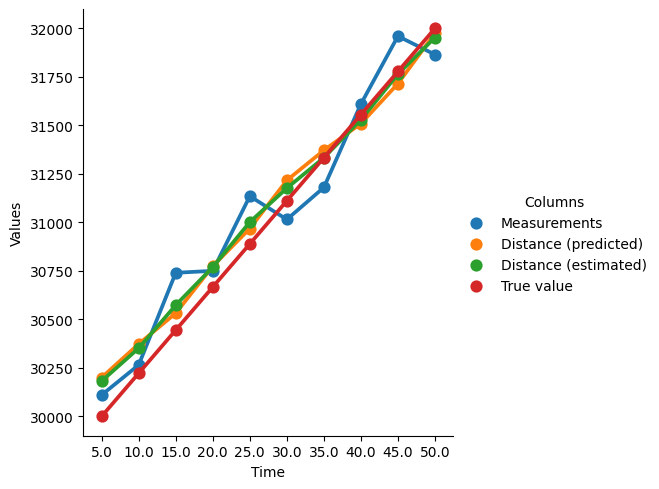

In [7]:
from typing import List
import pandas as pd
import seaborn as sns
import numpy as np


def extrapolate_distance(distance: float, speed: float, interval: float) -> float:
    return distance + (interval * speed)


def extrapolate_speed(speed: float) -> float:
    return speed


def update_distance(distance: float, alpha: float, measurement: float) -> float:
    return distance + (alpha * (measurement - distance))


def update_speed(
    speed: float, beta: float, measurement: float, distance: float, interval: float
) -> float:
    return speed + (beta * ((measurement - distance) / interval))


def calculate_movement_data(
    starting_distance: float,
    starting_speed: float,
    interval: float,
    alpha: float,
    beta: float,
    measurements: List[float],
) -> pd.DataFrame:
    # obliczamy pierwszy stan na podstawie początkowego
    distance_predictions = [
        extrapolate_distance(starting_distance, starting_speed, interval)
    ]
    speed_predictions = [extrapolate_speed(starting_speed)]
    distance_estimates = []
    speed_estimates = []

    # a następnie wszystkie kolejne na podstawie pomiarów
    for n in range(len(measurements)):
        predicted_distance = distance_predictions[n]
        predicted_speed = speed_predictions[n]
        measurement = measurements[n]

        estimated_distance = update_distance(predicted_distance, alpha, measurement)
        estimated_speed = update_speed(
            predicted_speed, beta, measurement, predicted_distance, interval
        )

        next_predicted_distance = extrapolate_distance(
            estimated_distance, estimated_speed, interval
        )
        next_predicted_speed = extrapolate_speed(estimated_speed)

        distance_estimates.append(estimated_distance)
        speed_estimates.append(estimated_speed)
        distance_predictions.append(next_predicted_distance)
        speed_predictions.append(next_predicted_speed)

    # stwórzmy ramkę danych do wizualizacji

    df_data = {
        "Time": np.linspace(5, 5 * len(measurements), len(measurements)),
        "Measurements": measurements,
        "Distance (predicted)": distance_predictions[:-1],
        "Distance (estimated)": distance_estimates,
        # "Speed (predicted)": speed_predictions[:-1],
        # "Speed (estimated)": speed_estimates,
        "True value": np.linspace(30000, 32000, len(measurements)),
    }

    return pd.DataFrame(df_data)


alpha: float = 0.2
beta: float = 0.1
interval: float = 5.0
starting_distance: float = 30000.0
starting_speed: float = 40.0
measurements: List[float] = [
    30110.0,
    30265.0,
    30740.0,
    30750.0,
    31135.0,
    31015.0,
    31180.0,
    31610.0,
    31960.0,
    31865.0,
]

df = calculate_movement_data(
    starting_distance, starting_speed, interval, alpha, beta, measurements
)

print(df)

sns_df = df.melt("Time", var_name="Columns", value_name="Values")

sns.catplot(data=sns_df, x="Time", y="Values", hue="Columns", kind="point")


Łatwo zauważyć, że estymowane i przewidywane wartości są bardzo bliskie rzeczywistych. Możemy też łatwo sprawdzić jak wyglądałyby obliczenia, gdybyśmy znacznie bardziej ufali wartościom otrzymywanym z radaru, poprzez zmianę wartości współczynników $\alpha$ i $\beta$ na większe:

   Time  Measurements  Distance (predicted)  Distance (estimated)  \
0   5.0       30110.0          30200.000000          30128.000000   
1  10.0       30265.0          30283.000000          30268.600000   
2  15.0       30740.0          30414.600000          30674.920000   
3  20.0       30750.0          30983.620000          30796.724000   
4  25.0       31135.0          30988.614000          31105.722800   
5  30.0       31015.0          31370.805800          31086.161160   
6  35.0       31180.0          31173.341260          31178.668252   
7  40.0       31610.0          31269.177722          31541.835544   
8  45.0       31960.0          31802.756153          31928.551231   
9  50.0       31865.0          32268.093763          31945.618753   

     True value  
0  30000.000000  
1  30222.222222  
2  30444.444444  
3  30666.666667  
4  30888.888889  
5  31111.111111  
6  31333.333333  
7  31555.555556  
8  31777.777778  
9  32000.000000  


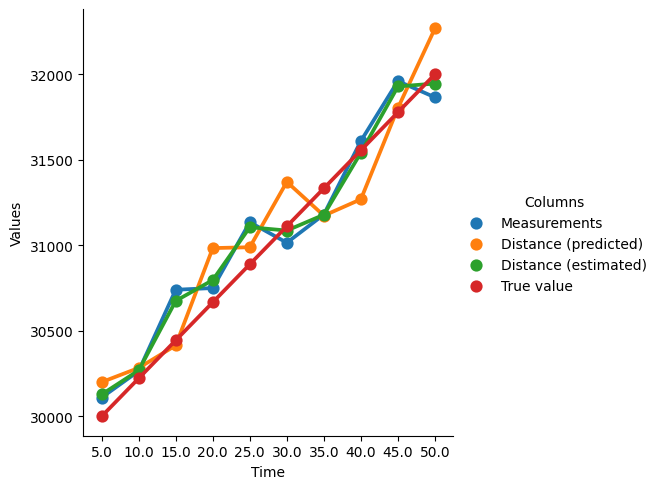

In [9]:
alpha: float = 0.8
beta: float = 0.5

df = calculate_movement_data(
    starting_distance, starting_speed, interval, alpha, beta, measurements
)

print(df)

sns_df = df.melt("Time", var_name="Columns", value_name="Values")

sns.catplot(data=sns_df, x="Time", y="Values", hue="Columns", kind="point")


Widzimy tutaj że estymowane i przewidywane wartości są znacznie bardziej "rozrzucone" i dalsze od prawdziwych wartości. Wynika to z niskiej dokładności naszego "radaru" - nasz algorytm jest w stanie poradzić sobie z dużą wariancją błędów pomiarowych, jeśli będzie wiedział że dane mają dużą wariancję. Jeśli każemy mu ufać bardziej danym to będą miały one mocniejszy wpływ na stan naszego systemu, co w efekcie spowoduje że będzie on bardziej narażony na wpływ błędów pomiarowych.

Skutkiem ubocznym mocniejszego "wygładzania" danych przez filtr jest większa bezwładność stanu - szybkość zmian stanu naszego filtra jest bezpośrednio zależna od wybranego współczynnika, więc w przypadku gdy system faktycznie zacznie zmieniać szybko swój stan, filtr "wygładzi" te zmiany i spowoduje że będą one widoczne znacznie "łagodniej". Może to działać na naszą niekorzyść, jeśli system który mierzymy jest w stanie szybko zmieniać swój stan i będziemy chcieli równie szybko wykrywać te zmiany.

Współczynniki alfa i beta należy dobierać do precyzji czujnika z którego otrzymujemy dane.

### Przykład 3 - śledzenie przyspieszającego samolotu w jednym wymiarze

W tym przykładzie zastosujemy filtr alfa-beta do śledzenia samolotu poruszającego się ze stałym przyspieszeniem. W poprzednim przykładzie, przyspieszenie było stałe i równe 0 - samolot leciał z prędkością 40m/s przez całą drogę.

<AxesSubplot:xlabel='Time (s)', ylabel='Range (km)'>

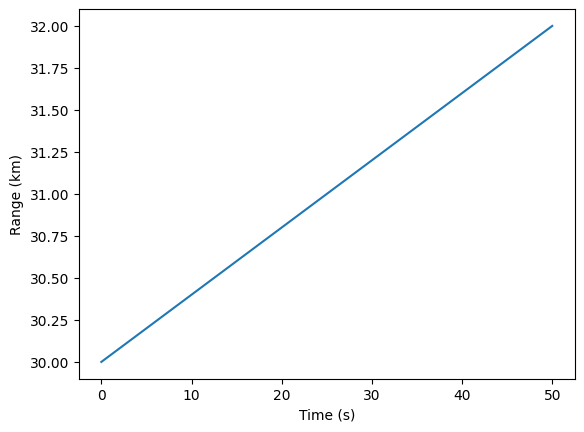

In [21]:
no_of_points = 250
time_points = np.linspace(0, 50, no_of_points)
range = np.linspace(30, 32, no_of_points)
velocity = np.linspace(40, 40, no_of_points)

df = pd.DataFrame({
    "Time (s)": time_points,
    "Range (km)": range,
    "Velocity (m/s)": velocity
})

sns.lineplot(x="Time (s)", y="Range (km)", data=df)

<AxesSubplot:xlabel='Time (s)', ylabel='Velocity (m/s)'>

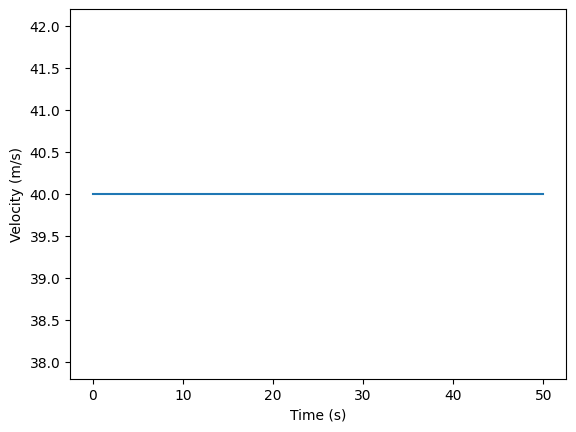

In [22]:
sns.lineplot(x="Time (s)", y="Velocity (m/s)", data=df)

Można łatwo zauważyć, że funkcja odległości jest liniowa.